# **Challenge 3 - Neural Networks**
* Sahil Gill, Luke Ingram
* MATH 318 - Winter 2023

In [36]:
import cv2 
import tensorflow as tf
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import os
import itertools

## **Section 1 - Why Neural Nets?**

From the previous challenge, we can conclude that classifying these images is difficult. Despite our best attempts at expanding the K-Nearest-Neighbors algorithm, our model's accuracy was is not what's desired from a classifier. So, once again, we try a more sophisticated approach. 

Which brings us to Neural Networks. Neural networks are complex, but flexible, and have soared in popularity over the last 10-15 years. One specific type of Neural Net, the **Convolutionary Neural Network** designed for image processing, is what we will be using to tackle the challenge of trash classification. 


## **Section 2 - The Architecture**

The basic structure of a CNN is as follows: 

1. Input layers 


### **Section 2.1 - MobileNetV2**

The network we'll be using is Google's MobileNetV2. This CNN was designed to meet the same accuracy you can see in VGG16 & VGG19, while training faster & running lighter.

The main difference between MobileNetV2 and the other popular image classifying CNNs is its use of *Depthwise convolutions*. 

#TODO ADD EXPLANATION OF DEPTHWISE VERSUS NORMAL CONV





### **Section 2.2 - Transfer Learning**

## **Section 3 - MobileNetV2 in Action**

Now it's time to put this into action. 

Before we begin, we need to load & normalize our data.

In [21]:
TARGET_NAMES =["Glass","Paper","Cardboard","Plastic","Metal","Trash"]

#Load data 
dirName = "../src/data/archive/zero-indexed-files.txt"
imgPath = "../src/data/archive/Garbage_classification/load/"

df = pd.read_csv(dirName,sep=' ')

df['image'] = imgPath + df['image'].astype(str)
df['image'] = df['image'].apply(lambda x: cv2.resize(cv2.imread(x),(224,224)))
print(df.head()) #DEBUG

train_X,test_X,train_Y,test_Y = train_test_split(df['image'],df['class'],
                                                 test_size=0.20,random_state=42,stratify=df['class'])


train_X,val_X,train_Y,val_Y = train_test_split(train_X,train_Y,
                                               test_size=0.20,random_state=42,stratify=train_Y)

# Normalize data 
train_X = train_X/255.0 
test_X = test_X/255.0
val_X = val_X/255.0

                                               image  class
0  [[[176, 189, 191], [177, 190, 192], [178, 191,...      0
1  [[[154, 167, 182], [151, 164, 180], [152, 165,...      0
2  [[[159, 171, 183], [157, 169, 181], [158, 170,...      0
3  [[[142, 154, 168], [142, 154, 168], [139, 151,...      0
4  [[[165, 177, 189], [165, 177, 189], [166, 178,...      0


### **Section 3.1 - Initializing MobileNetV2**

Keras provides us with an implementation of the MobileNetV2 network, we only have to specify the hyperparameters as follows: 

In [28]:
#Fetch network from keras, & define custom params. 
# This is a pre-trained model,but we remove the last layer 
# & train it ourselves to fit out problem
mobile_layer = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape = (224,224,3), # our images are in the shape
    alpha = 1.0, # using default input width
    include_top = False, #include fully-connected input layer
    weights = 'imagenet', # Default weights
    input_tensor = None, # using default input tensor structure
    pooling = None, # not using this feature
    classes = 1000, # default for MobileNet
    classifier_activation = 'softmax' #specify activation function of output layer
)   

# Make sure existing layers (convolutionary & pooling) remain untouched
mobile_layer.trainable = False

**Section 3.2 - Customized Output Layers**

TODO: Explain the transfer learning step & why we are using this many layers

In [32]:
model = tf.keras.models.Sequential()


model.add(tf.keras.Input(shape=(224,224,3))) # add our input layer
model.add(mobile_layer)# attach the pretrained portion of the model


# add our custom layers
model.add(tf.keras.layers.GlobalAvgPool2D()) # add an additional pooling layer
model.add(tf.keras.layers.Dense(6,activation='softmax')) # add softmax output layer

# Compile final model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam', # adam optimizer for Stochastic Gradient Descent
    metrics = ['accuracy']
)
    

### **Section 3.3 - Training the Model**

TODO: explain stochastic gradient descent

Epoch 1/30
51/51 [==============================] - 10s 185ms/step - loss: 1.2925 - accuracy: 0.4722 - val_loss: 0.8661 - val_accuracy: 0.6494
Epoch 2/30
51/51 [==============================] - 9s 177ms/step - loss: 0.7084 - accuracy: 0.7395 - val_loss: 0.6679 - val_accuracy: 0.7284
Epoch 3/30
51/51 [==============================] - 9s 176ms/step - loss: 0.5641 - accuracy: 0.7995 - val_loss: 0.5821 - val_accuracy: 0.7852
Epoch 4/30
51/51 [==============================] - 9s 180ms/step - loss: 0.4782 - accuracy: 0.8348 - val_loss: 0.5407 - val_accuracy: 0.7975
Epoch 5/30
51/51 [==============================] - 9s 181ms/step - loss: 0.4208 - accuracy: 0.8620 - val_loss: 0.5299 - val_accuracy: 0.7877
Epoch 6/30
51/51 [==============================] - 9s 182ms/step - loss: 0.3776 - accuracy: 0.8861 - val_loss: 0.5007 - val_accuracy: 0.8247
Epoch 7/30
51/51 [==============================] - 9s 181ms/step - loss: 0.3408 - accuracy: 0.8948 - val_loss: 0.4889 - val_accuracy: 0.8099
Epoch

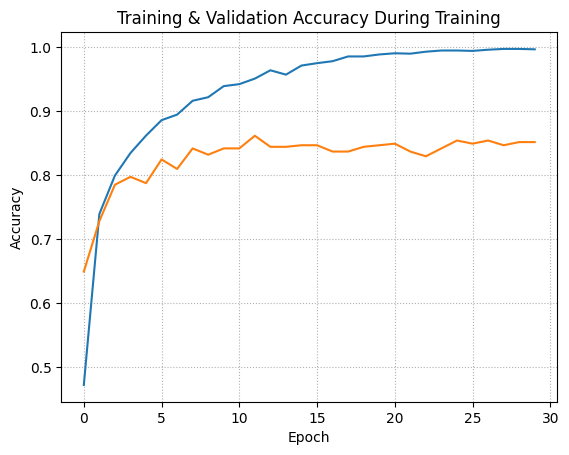

16/16 [==============================] - 2s 141ms/step - loss: 0.6056 - accuracy: 0.8004


[0.60560142993927, 0.8003952503204346]

In [33]:
# Convert to float for tensor conversion 
train_X = np.asarray(list(train_X),dtype='float32')
test_X = np.asarray(list(test_X),dtype='float32')
val_X = np.asarray(list(val_X),dtype='float32')


training_history = model.fit(train_X,train_Y,epochs = 30,validation_data=(val_X,val_Y))

plt.clf()
plt.rc('axes', axisbelow=True)
plt.grid(linestyle='dotted')
plt.plot(training_history.history['accuracy'],label='accuracy')
plt.plot(training_history.history['val_accuracy'],label = 'val_accuracy')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.title('Training & Validation Accuracy During Training')

plt.show() # TODO MAKE PLOT FOR TRAINING & VALIDATION ACCURACY


model.evaluate(test_X,test_Y) 

In [34]:
# Using trained model, make prediction testing data
res = model.predict(test_X)

16/16 [==============================] - 3s 139ms/step


## **Section 4 - Results & Comparison with Previous Methods**

Now that we've trained our model, lets evaluate it's performance.

For this we will be using the same evaluation function seen in the previous challenge. 

              precision    recall  f1-score   support

       Glass       0.69      0.75      0.72       100
       Paper       0.86      0.93      0.90       119
   Cardboard       0.96      0.86      0.91        81
     Plastic       0.79      0.70      0.74        97
       Metal       0.76      0.78      0.77        82
       Trash       0.68      0.63      0.65        27

    accuracy                           0.80       506
   macro avg       0.79      0.78      0.78       506
weighted avg       0.80      0.80      0.80       506



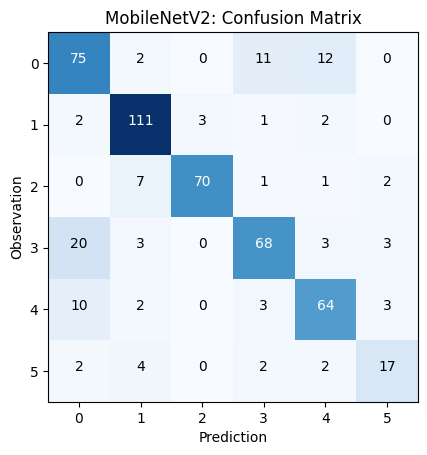

In [41]:
# Compute evaluation given classification results 
def evaluate(Y_hat,Y_truth): 
    print(classification_report(Y_truth,Y_hat,target_names=TARGET_NAMES))
    cm = confusion_matrix(Y_truth, Y_hat)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.title("MobileNetV2: Confusion Matrix")
    plt.xlabel("Prediction")
    plt.ylabel("Observation")
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

evaluate([np.argmax(r) for r in res],test_Y)